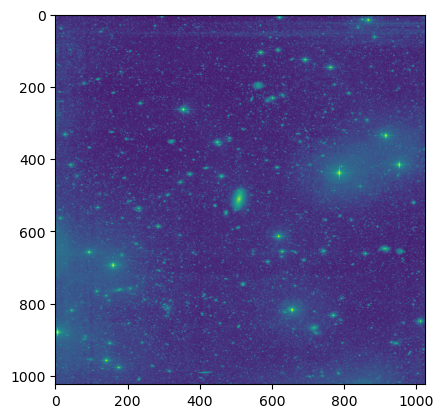

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os
import cv2

import random
from copy import deepcopy

# Load the .npy file
file_name = "../datasets/matlas_images_and_annotations/images/name=IC0598.npy"
data = np.load(file_name)

# Display the data
plt.imshow(data[0,:,:])
plt.show()

In [49]:
file_path = "../datasets/matlas_images_and_annotations/"
annotation_file_path = file_path + "annotations/standard/double/basichalosnocompanions_splittidal/"

# structure_name = {}
# mask_files_name = {}

# structure_name["Elongated tidal structures"] = "Elongated tidal structures"
# mask_files_name["Elongated tidal structures"] = glob.glob(annotation_file_path + "*" + structure_name["Elongated tidal structures"] + ".npz")

# # get the label file that has tidal structures then link to npy file
# structure_files_name = ["=".join(structure_file.split("/")[-1].split('=')[:2])[:-6] + ".npy" for structure_file in mask_files_name["Elongated tidal structures"]]

# structure_name["Diffuse halo"] = "Diffuse halo"
# mask_files_name["Diffuse halo"] = [annotation_file_path + "=".join(structure_file.split("/")[-1].split('=')[:2] + [structure_name["Diffuse halo"]]) + ".npz" for structure_file in mask_files_name["Elongated tidal structures"]]

# structure_name["Galaxy"] = "Galaxy"
# mask_files_name["Galaxy"] = [annotation_file_path + "=".join(structure_file.split("/")[-1].split('=')[:2] + [structure_name["Galaxy"]]) + ".npz" for structure_file in mask_files_name["Elongated tidal structures"]]

# structure_name["Elongated tidal structures"] = "Elongated tidal structures"
# mask_files_name["Elongated tidal structures"] = glob.glob(annotation_file_path + "*" + structure_name["Elongated tidal structures"] + ".npz")

In [50]:
images_path = glob.glob(os.path.join(file_path,"images","*"))

In [51]:
f = images_path[0].split("/")[-1].split("=")[1][:-4]


In [52]:
from scipy import ndimage

def decode_np_mask(array):
    shape, mask, centre = array['shape'], array['mask'], array['centre']
    mask = np.unpackbits(mask)
    mask = mask[:np.prod(shape)]
    
    return mask.reshape(shape), centre

def getMask(mask_files_name, mask_files_name2=None):
    mask_path = mask_files_name
    mask_path2 = mask_files_name2
    # try:
    if mask_files_name2 == None:
        mask = decode_np_mask(np.load(mask_path, allow_pickle=True))[0]
        mask = mask[np.count_nonzero(mask, axis=(1, 2)) > 0]
        return mask
    
    else:
        mask1 = decode_np_mask(np.load(mask_path, allow_pickle=True))[0]
        mask2 = decode_np_mask(np.load(mask_path2, allow_pickle=True))[0]
        print(mask2.shape)
        cm1 = [ndimage.center_of_mass(mask) for mask in mask1]
        cm2 = [ndimage.center_of_mass(mask) for mask in mask2]
        
        for i, cm in enumerate(cm2): 
            min_idx = np.argmin(np.linalg.norm(np.array(cm1) - cm, axis=1))

            mask = mask1
            mask[min_idx] = np.logical_or(mask1[min_idx], mask2[i])
        
        mask = mask[np.count_nonzero(mask, axis=(1, 2)) > 0]
        return mask
    
def encode_np_mask(mask, file_name):
    shape = mask.shape
    mask = np.packbits(mask)
    np.savez(file_name, shape=shape, mask=mask, centre=None)

In [59]:
foo = dict()


'[146 183   6 144  76 174 134  93 141   8  38 145  70 102 159 122 161  45\n  97  90  39 110 173  51 155 179  83 131 151 148 178  33 126 113   3  65\n 158  43 136  18 116  94  23  22 107  49   7  19  35  54  36  67  74  68\n 114  42 166 171 149   9 157 117 120  55 142 115  60  29  84  10  57  91\n  71  66 138 133 162  31 108 152 139 103 112 163 132 177  50  44 147 156\n  96 167 121  14  41 143  72  85  64 129 109 111 165  80 104  48  52  15\n 127 135  82 169  46  40  63 175  13 170 160   1 101  24 119 140  20  17\n 125 118 130 172  12  81  21  86  53  47  27  58  56 123  89  28  62  61\n  77 180  87]'

In [117]:
idxs = np.arange(0,len(images_path))
np.random.shuffle(idxs)

train_ratio = 0.80
train_idx, test_idx = idxs[0:int(train_ratio*idxs.shape[0])], idxs[int(train_ratio*idxs.shape[0]):]
_struct_dict = {"Diffuse halo":0, 
                "Galaxy":0, 
                "Elongated tidal structures":0,
                "Ghosted halo":0
            }
struct_dict = {"train": deepcopy(_struct_dict), "test": deepcopy(_struct_dict)}
struct_dict_detail = {"train": deepcopy(_struct_dict), "test": deepcopy(_struct_dict)}
pstruct_dict = {"train": deepcopy(_struct_dict), "test": deepcopy(_struct_dict)}
pstruct_dict_detail = {"train": deepcopy(_struct_dict), "test": deepcopy(_struct_dict)}



for j,k in zip([train_idx, test_idx],["train","test"]):
    for i in j:
        file_name = images_path[i].split("/")[-1].split("=")[1][:-4]
        for structure_name in _struct_dict.keys():
            annote_name = "name=" + file_name + "-class=" + structure_name + ".npz"
            p = os.path.join(annotation_file_path, annote_name)
            if os.path.isfile(p):
                struct_dict[k][structure_name] += 1
                mask,_ = decode_np_mask(np.load(p, allow_pickle=True))
                struct_dict_detail[k][structure_name] += mask.shape[0]
for j in ["train","test"]:
    for structure_name in _struct_dict.keys():
        pstruct_dict[j][structure_name] = struct_dict[j][structure_name]/(struct_dict["train"][structure_name] + struct_dict["test"][structure_name])
        pstruct_dict_detail[j][structure_name] = struct_dict_detail[j][structure_name]/(struct_dict_detail["train"][structure_name] + struct_dict_detail["test"][structure_name])


In [118]:
print(struct_dict)
print(struct_dict_detail)
print(pstruct_dict)
print(pstruct_dict_detail)

{'train': {'Diffuse halo': 144, 'Galaxy': 147, 'Elongated tidal structures': 45, 'Ghosted halo': 117}, 'test': {'Diffuse halo': 36, 'Galaxy': 37, 'Elongated tidal structures': 10, 'Ghosted halo': 28}}
{'train': {'Diffuse halo': 281, 'Galaxy': 233, 'Elongated tidal structures': 116, 'Ghosted halo': 271}, 'test': {'Diffuse halo': 65, 'Galaxy': 57, 'Elongated tidal structures': 28, 'Ghosted halo': 60}}
{'train': {'Diffuse halo': 0.8, 'Galaxy': 0.7989130434782609, 'Elongated tidal structures': 0.8181818181818182, 'Ghosted halo': 0.8068965517241379}, 'test': {'Diffuse halo': 0.2, 'Galaxy': 0.20108695652173914, 'Elongated tidal structures': 0.18181818181818182, 'Ghosted halo': 0.19310344827586207}}
{'train': {'Diffuse halo': 0.8121387283236994, 'Galaxy': 0.803448275862069, 'Elongated tidal structures': 0.8055555555555556, 'Ghosted halo': 0.8187311178247734}, 'test': {'Diffuse halo': 0.18786127167630057, 'Galaxy': 0.19655172413793104, 'Elongated tidal structures': 0.19444444444444445, 'Ghoste

In [107]:
import shutil

for j,k in zip([train_idx, test_idx],["train","test"]):
    for i in j:
        shutil.copy(images_path[i], os.path.join(file_path, "images2", k))